## Sentiment Analysis

* Sentiment Intensity Analyzer
* Preprocessing
* LSTM layer model
* Confusion matrix


In [1]:
#!pip install keras --upgrade
import re
import glob
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

plt.style.use('ggplot')

/kaggle/input/amazonearphonesreviews/AllProductReviews.csv
/kaggle/input/amazonearphonesreviews/ProductInfo.csv


### Load DF

In [2]:
df_dir = "../input/amazonearphonesreviews"
dfs = [pd.read_csv(df) for df in glob.glob(df_dir + "/*.csv")]

df = dfs[0]
df_2 = dfs[1]
df.head()
df_2.head()

,MRP,Price,ProductFullName,ProductShortName,ReviewURL,id
0,2990,1399,boAt Rockerz 255 Sports Bluetooth Wireless Ear...,boAt Rockerz 255,https://www.amazon.in/255-Bluetooth-Wireless-E...,1
1,3999,1099,Flybot Wave in-Ear Sport Wireless Bluetooth Ea...,Flybot Wave,https://www.amazon.in/Flybot-Wireless-Bluetoot...,2
2,3999,1099,Flybot Boom Deep Bass in-Ear Wireless Bluetoot...,Flybot Boom,https://www.amazon.in/Flybot-Wireless-Bluetoot...,3
3,2000,749,PTron Intunes Pro Headphone Magnetic Earphone ...,PTron Intunes,https://www.amazon.in/PTron-Intunes-Pro-Smartp...,4
4,5999,2999,Flybot Beat True Wireless Bluetooth Earphones ...,Flybot Beat,https://www.amazon.in/Flybot-Wireless-Bluetoot...,5


### Average rating for each product

In [3]:
rev_mean = df.groupby('Product', as_index=False)['ReviewStar'].mean()
print(rev_mean)

                 Product  ReviewStar
0            Flybot Beat    4.391304
1            Flybot Boom    4.243902
2            Flybot Wave    3.851648
3             JBL T110BT    3.047347
4             JBL T205BT    3.367116
5          PTron Intunes    3.889764
6  Samsung EO-BG950CBEIN    3.566964
7    Sennheiser CX 6.0BT    4.048200
8  Skullcandy S2PGHW-174    3.230126
9       boAt Rockerz 255    3.628600


### Plotting average rating and price for each product

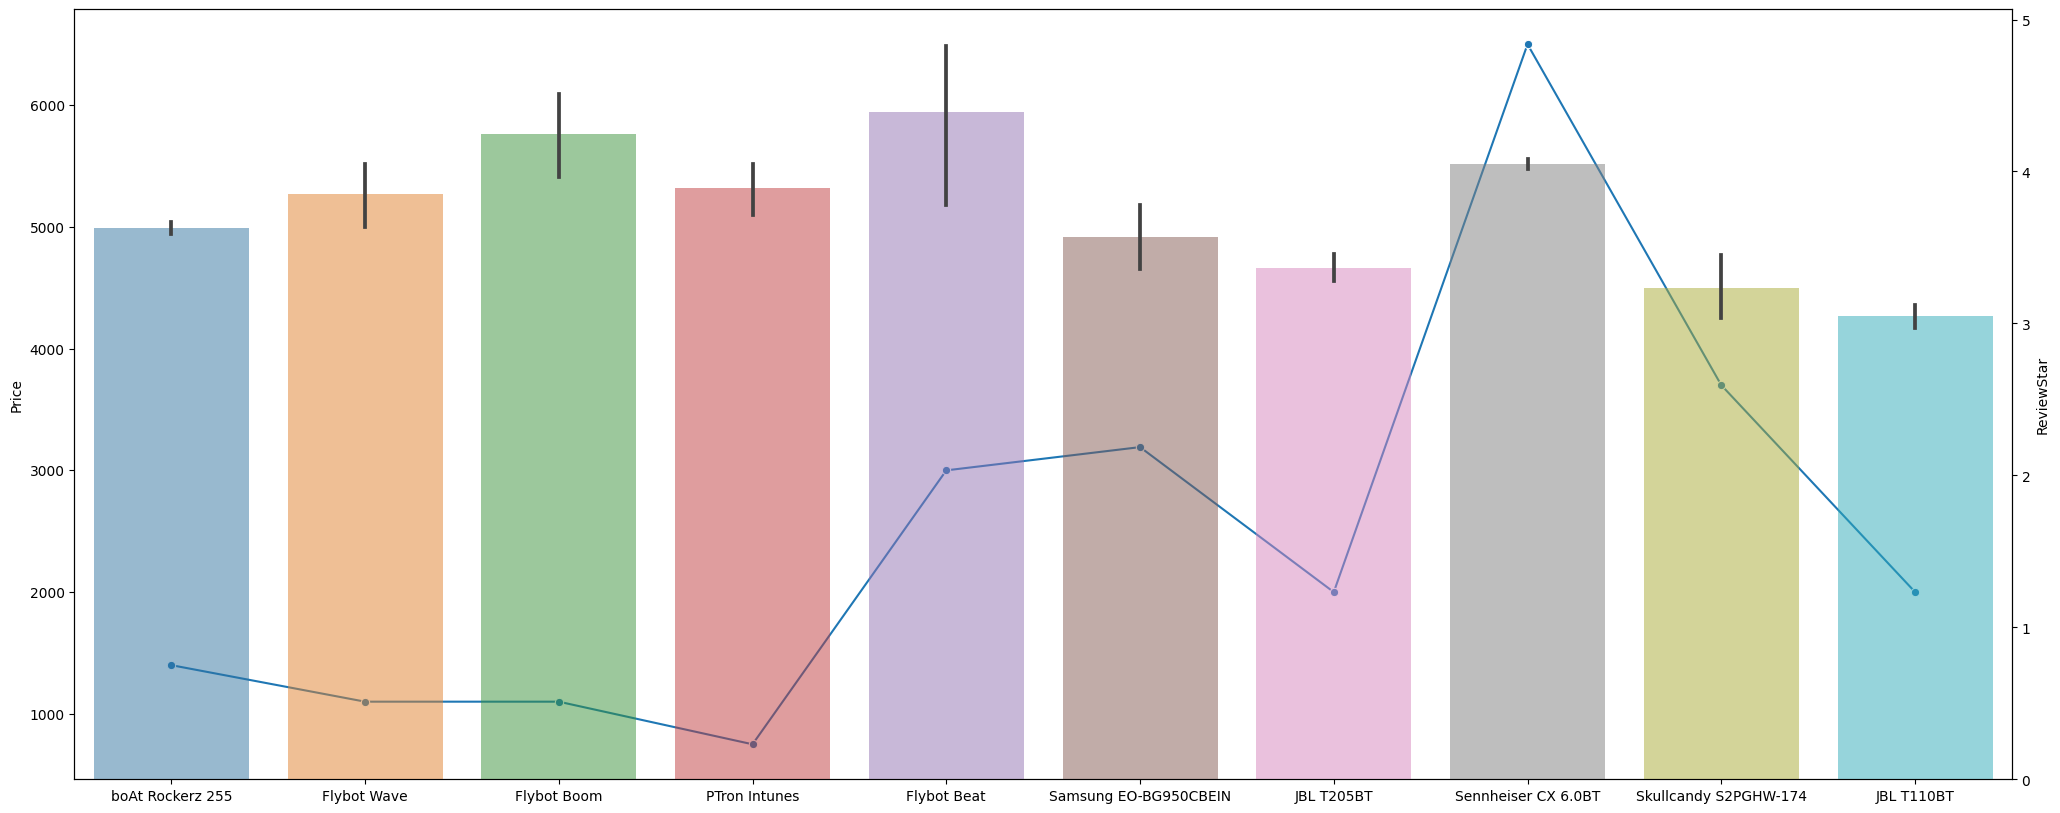

In [4]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None)

fig, ax1 = plt.subplots(figsize=(25,10))
sns.lineplot(data=df_2["Price"], marker='o', sort=False, ax=ax1)
ax2 = ax1.twinx()
sns.barplot(data=df, x="Product", y="ReviewStar", alpha=0.5, ax=ax2)
plt.show()

### Calculate polarity scores for each row in reviews

In [5]:
sia = SentimentIntensityAnalyzer()

rev = {}
for i, row in enumerate(df["ReviewBody"]):
    review = row
    id_x = i
    rev[id_x] = sia.polarity_scores(review)

rev = pd.DataFrame(rev).T
rev = rev.reset_index().rename(columns={'index':'id'})

## concat the scores to main dataframe

df_main = pd.concat([rev, df], axis=1)
df_main.head()

,id,neg,neu,pos,compound,ReviewTitle,ReviewBody,ReviewStar,Product
0,0,0.268,0.657,0.075,-0.9580,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,1,0.073,0.884,0.043,-0.2528,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,2,0.021,0.928,0.052,0.5569,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,3,0.061,0.833,0.105,0.1779,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,4,0.093,0.760,0.147,0.2831,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


### Add a column with max_score and max_id
* Each review is assigned the score id in response to the highest score

In [6]:
df_main["max_score"] = df_main[["neg","neu","pos"]].max(axis=1)
df_main["max_id"] = df_main[["neg","neu","pos"]].idxmax(1)
df_main = df_main[["id", "neg","neu","pos","max_score", "max_id","ReviewBody","ReviewStar", "Product"]]
print(df_main)

          id    neg    neu    pos  max_score max_id  \
0          0  0.268  0.657  0.075      0.657    neu   
1          1  0.073  0.884  0.043      0.884    neu   
2          2  0.021  0.928  0.052      0.928    neu   
3          3  0.061  0.833  0.105      0.833    neu   
4          4  0.093  0.760  0.147      0.760    neu   
...      ...    ...    ...    ...        ...    ...   
14332  14332  0.000  0.000  1.000      1.000    pos   
14333  14333  0.200  0.500  0.300      0.500    neu   
14334  14334  0.000  1.000  0.000      1.000    neu   
14335  14335  0.000  0.674  0.326      0.674    neu   
14336  14336  0.103  0.788  0.109      0.788    neu   

                                              ReviewBody  ReviewStar  \
0      No doubt it has a great bass and to a great ex...           3   
1      This  earphones are unreliable, i bought it be...           1   
2      i bought itfor 999,I purchased it second time,...           4   
3      Its sound quality is adorable. overall it wa

### Plotting scores for each product

<Figure size 2500x1000 with 0 Axes>

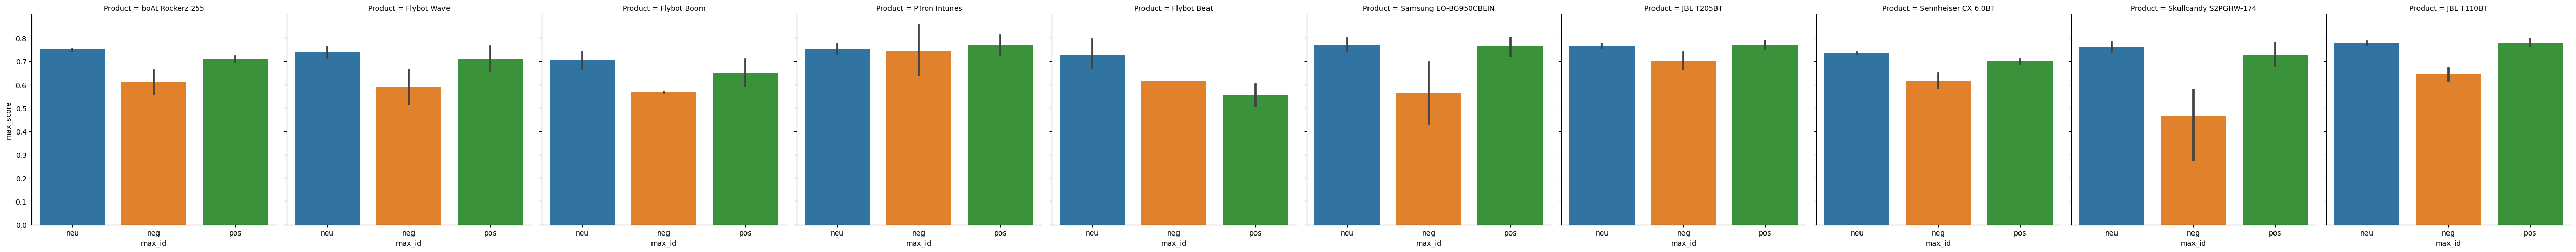

In [7]:
plt.figure(figsize=(25,10))
sns.catplot(data=df_main, x="max_id", y="max_score", col="Product", kind="bar")
plt.show()

### Plotting to compare reviews and polarity scores 

Text(0.5, 1.0, 'negative')

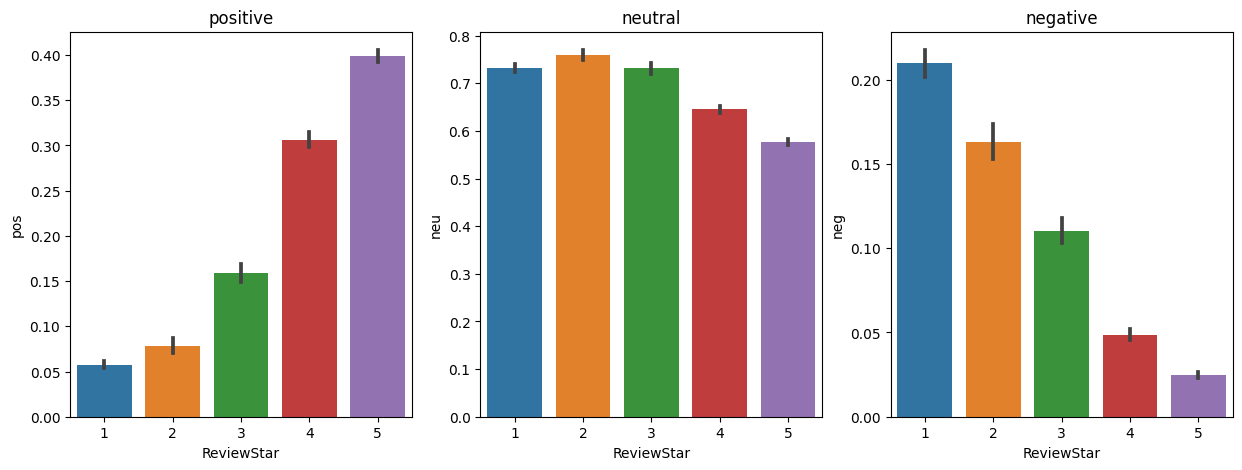

In [8]:
fig, axs= plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=df_main, x="ReviewStar", y="pos", ax=axs[0])
sns.barplot(data=df_main, x="ReviewStar", y="neu", ax=axs[1])
sns.barplot(data=df_main, x="ReviewStar", y="neg", ax=axs[2])
axs[0].set_title('positive')
axs[1].set_title('neutral')
axs[2].set_title('negative')

### Preprocessing: 
* removing certain characters from texts
* sentences to words
* detokenize

In [9]:
def depure_data(data):
    """remove new line 
    chars and single quotes"""    
    data = re.sub('\s+', ' ', data)
    data = re.sub("\'", "", data)        
    return data


data = [depure_data(i) for i in df_main["ReviewBody"]]

tmp = []
for i in range(len(data)):
    tmp.append(depure_data(data[i]))
list(tmp[:5])


['No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice. ',
 'This earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying\u200b this unreliable product.Thanks. ',
 'i bought itfor 999,I purchased it second time, gifted first one to brother. This is really good.Sound quality is really good.You can connect 2 devices at a time.I connect

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        

data_words = list(sent_to_words(tmp))

print(data_words[:10])
#print(len(data_words))

[['no', 'doubt', 'it', 'has', 'great', 'bass', 'and', 'to', 'great', 'extent', 'noise', 'cancellation', 'and', 'decent', 'sound', 'clarity', 'and', 'mindblowing', 'battery', 'but', 'the', 'following', 'dissapointed', 'me', 'though', 'tried', 'lot', 'to', 'adjust', 'bluetooth', 'range', 'not', 'more', 'than', 'pain', 'in', 'ear', 'due', 'the', 'conical', 'buds', 'can', 'be', 'removed', 'wires', 'are', 'bit', 'long', 'which', 'makes', 'it', 'odd', 'in', 'front', 'no', 'pouch', 'provided', 'worst', 'part', 'is', 'very', 'low', 'quality', 'and', 'distoring', 'mic', 'other', 'person', 'keeps', 'complaining', 'about', 'my', 'voice'], ['this', 'earphones', 'are', 'unreliable', 'bought', 'it', 'before', 'days', 'meanwhile', 'right', 'side', 'ear', 'buds', 'got', 'cracked', 'automatically', 'and', 'it', 'got', 'divided', 'in', 'two', 'parts', 'and', 'sound', 'quality', 'is', 'also', 'not', 'that', 'much', 'good', 'but', 'ok', 'one', 'more', 'thing', 'bass', 'is', 'not', 'good', 'as', 'it', 'is'

In [11]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [12]:
d = [detokenize(data_words[i]) for i in range(len(data_words))]
print(d[:5])

['no doubt it has great bass and to great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though tried lot to adjust bluetooth range not more than pain in ear due the conical buds can be removed wires are bit long which makes it odd in front no pouch provided worst part is very low quality and distoring mic other person keeps complaining about my voice', 'this earphones are unreliable bought it before days meanwhile right side ear buds got cracked automatically and it got divided in two parts and sound quality is also not that much good but ok one more thing bass is not good as it is boat earphones guys also for the proof have attached picsplease see and think before buying this unreliable product thanks', 'bought itfor purchased it second time gifted first one to brother this is really good sound quality is really good you can connect devices at time connect laptop and mobile both when listening muaic on lappy if get call it

### Convert data to numpy array

In [13]:
data = np.array(d)

### Further imports 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop,Adam
from keras import backend as K
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras import utils
from keras import regularizers
from keras.callbacks import ModelCheckpoint


#### Changing score values to float

In [15]:
labels = np.array(df_main['max_id'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neu':
        y.append(0)
    if labels[i] == 'neg':
        y.append(1)
    if labels[i] == 'pos':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [16]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
reviews = pad_sequences(sequences, maxlen=max_len)
print(reviews)

[[   0    0    0 ...  128   30  119]
 [   0    0    0 ... 1795   10  286]
 [   0    0    0 ...  141   25   40]
 ...
 [   0    0    0 ...    0    0    6]
 [   0    0    0 ...   16    4   10]
 [   0    0    0 ...  136  282  224]]


### Split data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(reviews,labels, random_state=0)
print("Train size: ", len(X_train), len(y_train))
print("Test size: ", len(X_test), len(y_test))

Train size:  10752 10752
Test size:  3585 3585


### Single LSTM layer model

In [18]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

2022-09-23 11:39:31.086367: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("lstm_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint])

2022-09-23 11:39:31.603282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70
336/336 [==============================] - 22s 58ms/step - loss: 0.4202 - accuracy: 0.8411 - val_loss: 0.3185 - val_accuracy: 0.8834

Epoch 00001: val_accuracy improved from -inf to 0.88340, saving model to lstm_model.hdf5
Epoch 2/70
336/336 [==============================] - 19s 56ms/step - loss: 0.2933 - accuracy: 0.8890 - val_loss: 0.2708 - val_accuracy: 0.8979

Epoch 00002: val_accuracy improved from 0.88340 to 0.89791, saving model to lstm_model.hdf5
Epoch 3/70
336/336 [==============================] - 19s 56ms/step - loss: 0.2482 - accuracy: 0.9044 - val_loss: 0.2358 - val_accuracy: 0.9054

Epoch 00003: val_accuracy improved from 0.89791 to 0.90544, saving model to lstm_model.hdf5
Epoch 4/70
336/336 [==============================] - 19s 56ms/step - loss: 0.2230 - accuracy: 0.9089 - val_loss: 0.2136 - val_accuracy: 0.9169

Epoch 00004: val_accuracy improved from 0.90544 to 0.91688, saving model to lstm_model.hdf5
Epoch 5/70
336/336 [==============================] - 1

In [20]:
lstm_model = keras.models.load_model("lstm_model.hdf5")
predictions = lstm_model.predict(X_test)

### Confusion Matrix

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


<AxesSubplot:>

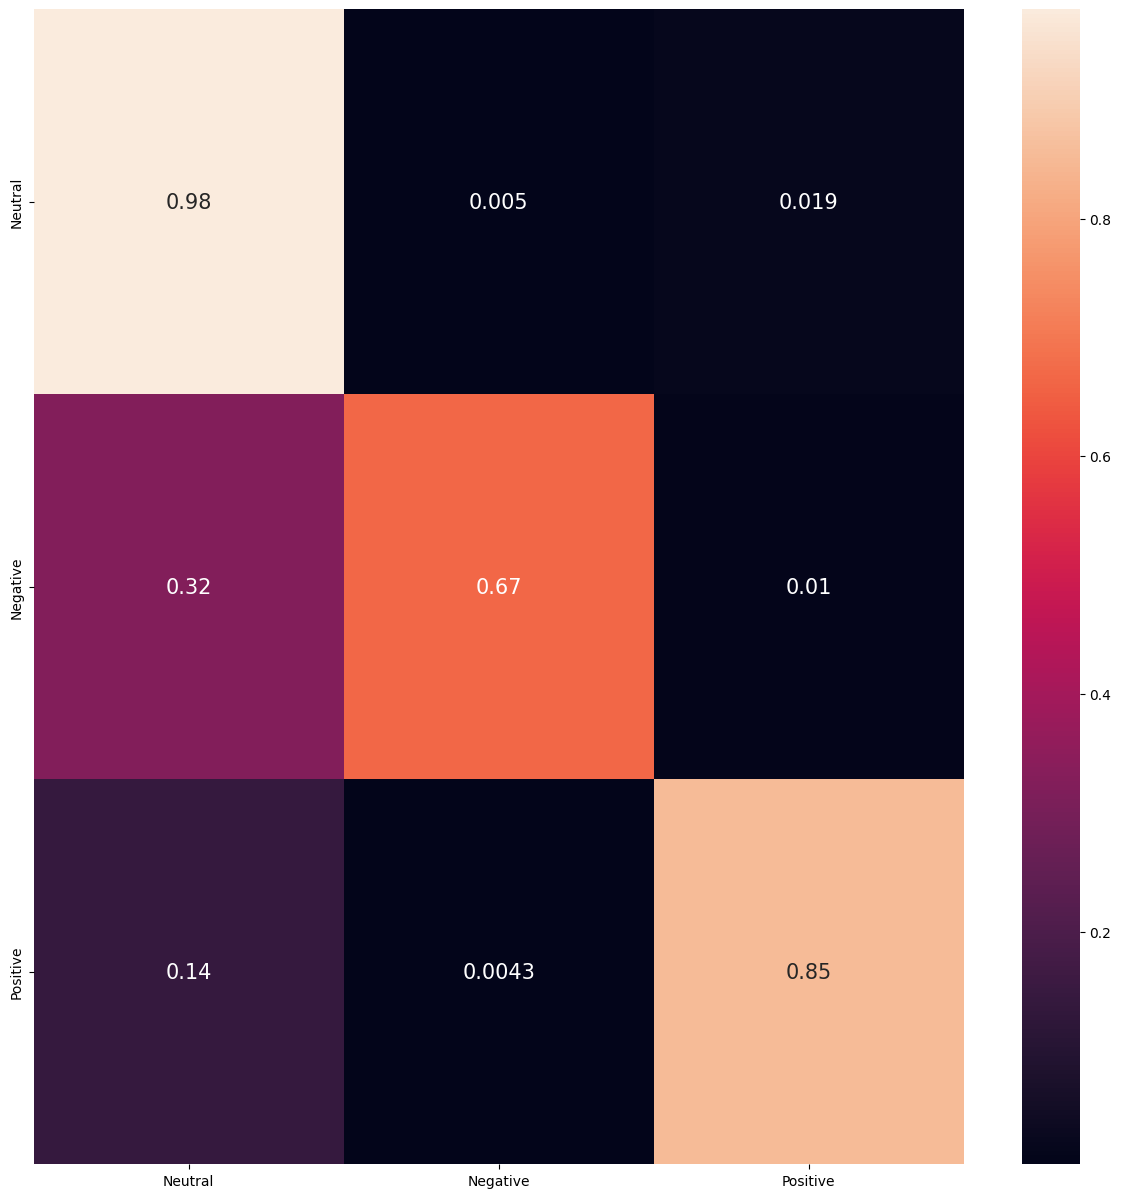

In [21]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})